In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline

import pandas as pd
from scipy.optimize import curve_fit
from utilities import compute_normalized_two_point_correlation

import json

def correlation_function(cov):
    p = cov[0]
    return (cov-p**2)/(p-p**2)

def straight_line_at_origin(porosity):
    def func(x, a):
        return a * x + porosity
    return func

In [2]:
#strings to output and input locations
beadpack_dic = {
    "out_direc": "./covariances/beadpack/",
    "seed_min": 43,
    "seed_max": 64,
    "tisize": 128
}

data_dic = beadpack_dic
out_direc = data_dic["out_direc"]

## Data Loading and Computation of radial averages

We load the two-point probability function data and perform radial averaging as well as normalizing to the correlation function.

$$ \kappa(r)=\frac{S^{(i)}_2(r)-\phi_{(i)}^2}{\phi_{(i)}-\phi_{(i)}^2}$$

In [3]:
orig_cov_pph = pd.read_csv(out_direc+"orig_pph.csv")
orig_cov_gph = pd.read_csv(out_direc+"orig_gph.csv")

radial_avg_orig_pph = np.mean(orig_cov_pph.values.T, axis=0)
radial_avg_orig_gph = np.mean(orig_cov_gph.values.T, axis=0)

print radial_avg_orig_pph.shape

correlation_func_orig = correlation_function(radial_avg_orig_pph)

(500L,)


We compute the slope of the correlation function at the origin for visualisation purposes only.

In [4]:
N = 5
slope_orig_corr, slope_orig_corr_cov = curve_fit(straight_line_at_origin(correlation_func_orig[0]), range(0, N), correlation_func_orig[0:N])
print slope_orig_corr

[-0.07707962]


## Data Loading Synthetic Samples and Processing

We perform the same computations for the synthetic samples and also compute the mean and standard deviation at  
each lag distance $r$ to show the validity of our matched models.

In [5]:
cov_data = None
with open(out_direc+"covariance_data.json", "r") as f:
    cov_data = json.load(f)

chord_lengths = []
orig_chord_length = None
for key in cov_data.keys():
    if key == 'orig':
        orig_chord_length = cov_data[key]['chord_length_gph']
    else:
        chord_lengths.append(cov_data[key]['chord_length_gph'])

In [6]:
avg_chord_length = np.mean(chord_lengths)
print orig_chord_length, avg_chord_length

35.8615397698 35.302006195


In [12]:
cov_pphs = []
cov_gphs = []
for i in range(data_dic["seed_min"], data_dic["seed_max"]):
    cov_pph = pd.read_csv(out_direc+"S_"+str(i)+"_pph.csv")
    cov_gph = pd.read_csv(out_direc+"S_"+str(i)+"_gph.csv")
    cov_pphs.append(cov_pph.values.T)
    cov_gphs.append(cov_gph.values.T)
    
cov_pphs = np.array(cov_pphs)
cov_gphs = np.array(cov_gphs)
print cov_pphs.shape

directional_averages_pph = np.mean(cov_pphs, axis=0)
directional_averages_gph = np.mean(cov_gphs, axis=0)

directional_std_pph = np.std(cov_pphs, axis=0)
directional_std_gph = np.std(cov_gphs, axis=0)

radial_averaged_corr = np.mean( [correlation_function(cov) for cov in cov_pphs.reshape(-1, cov_pphs.shape[-1])], axis=0)
radial_std_corr = np.std([correlation_function(cov) for cov in cov_pphs.reshape(-1, cov_pphs.shape[-1])], axis=0)

slope_synth_corr, slope_synth_corr_cov = curve_fit(straight_line_at_origin(radial_averaged_corr[0]), range(0, N), radial_averaged_corr[0:N])

directional_x = np.array([correlation_function(cov) for cov in cov_pphs[:, 0, :]])
directional_y = np.array([correlation_function(cov) for cov in cov_pphs[:, 1, :]])
directional_z = np.array([correlation_function(cov) for cov in cov_pphs[:, 2, :]])

directional_averages_normalized = np.zeros((3, directional_x.shape[1]))
directional_std_normalized = np.zeros((3, directional_x.shape[1]))

directional_averages_normalized[0] = np.mean(directional_x, axis=0)
directional_averages_normalized[1] = np.mean(directional_y, axis=0)
directional_averages_normalized[2] = np.mean(directional_z, axis=0)

directional_std_normalized[0] = np.std(directional_x, axis=0)
directional_std_normalized[1] = np.std(directional_y, axis=0)
directional_std_normalized[2] = np.std(directional_z, axis=0)

orig_normalized = np.array([correlation_function(cov) for cov in orig_cov_pph.values.T])

(21L, 3L, 200L)


## Directional Two-Point Probability Function Pore Phase including errorbars

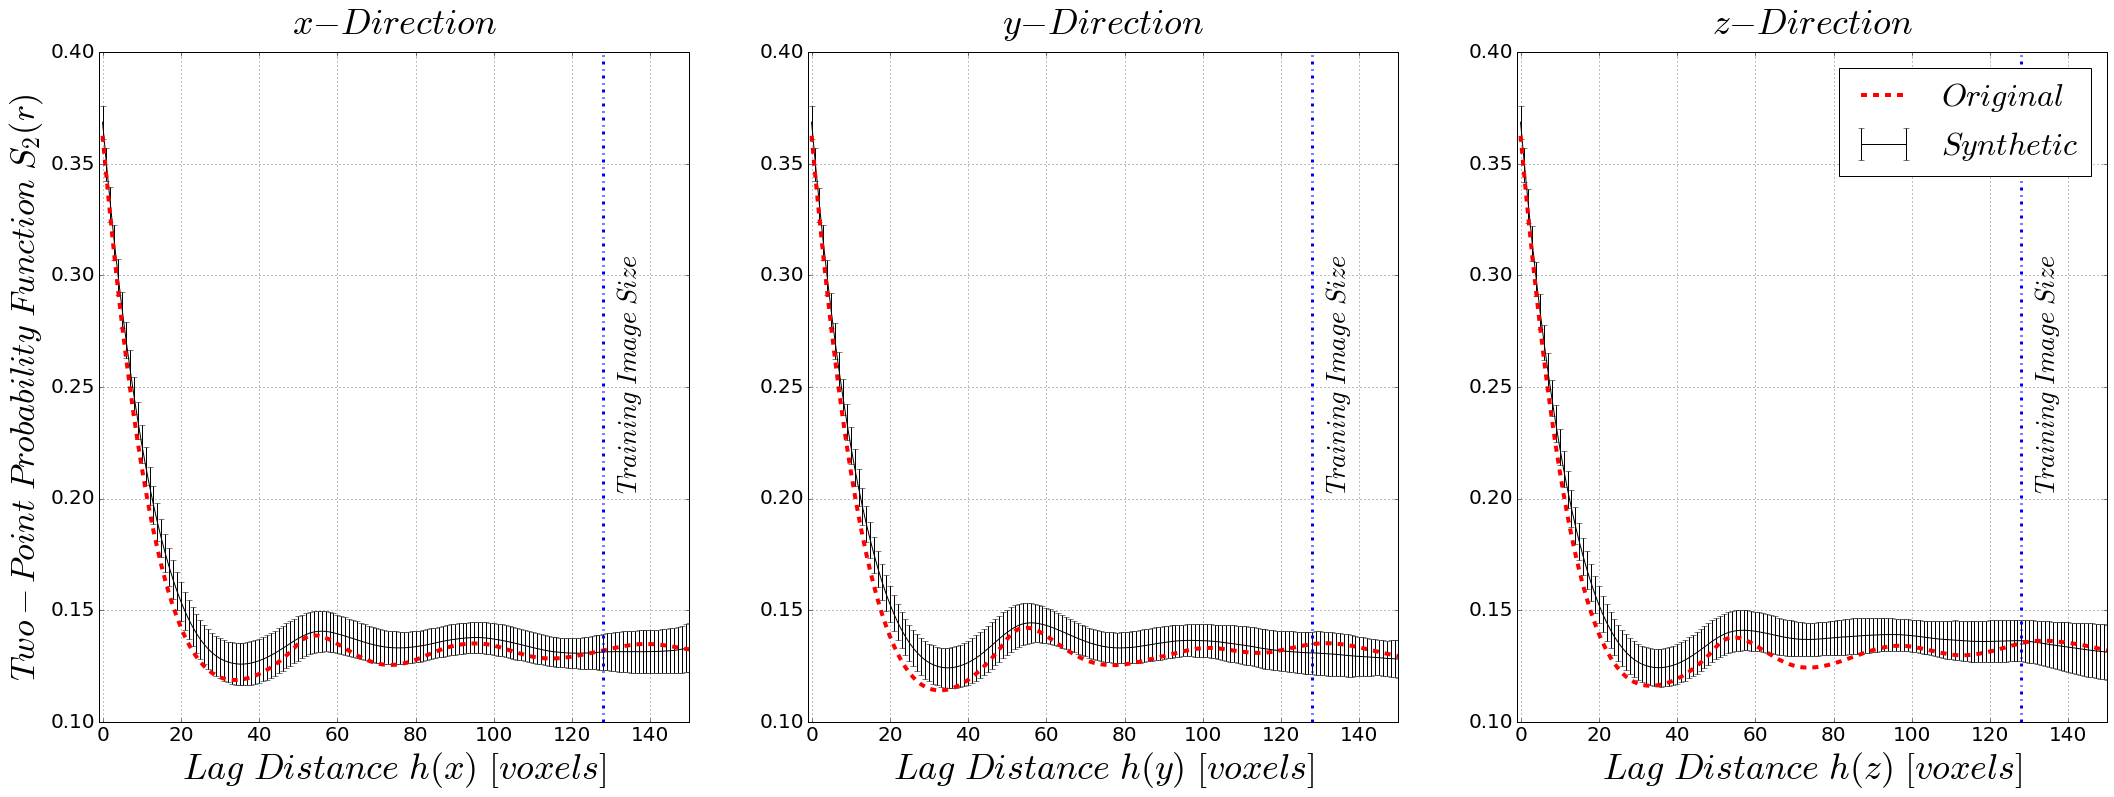

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)
for i, (j, direc) in zip(range(0, 6, 2), enumerate([r"$x$", r"$y$", r"$z$"])):    
    if j == 2:
        ax[j].errorbar(range(len(directional_averages_pph[j])), directional_averages_pph[j], yerr=directional_std_pph[j], c="black", fmt='-', label=r"$Synthetic$")
        ax[j].plot(range(len(orig_cov_pph.values.T[j])), orig_cov_pph.values.T[j], linestyle="--", linewidth=4, c="red", label=r"$Original$")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.3,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        ax[j].legend(fontsize=32)
    else:
        ax[j].errorbar(range(len(directional_averages_pph[j])), directional_averages_pph[j], yerr=directional_std_pph[j], c="black", fmt='-')
        ax[j].plot(range(len(orig_cov_pph.values.T[j])), orig_cov_pph.values.T[j], linestyle="--", linewidth=4, c="red")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.3,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        
    for tick in ax[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    for tick in ax[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
for j, direc in enumerate([r"$x$", r"$y$", r"$z$"]):
    ax[j].set_title(direc+r"$-Direction$", fontsize=36, y=1.02) 
    ax[j].set_xlabel(r"$Lag \ Distance \ h($"+direc+"$) \ [voxels]$", fontsize=36) 

ax[0].set_ylabel(r"$Two-Point \ Probability \ Function \ S_2(r)$", fontsize=34)    
for ax_handle in ax.flatten():
    ax_handle.set_xlim(-1, 150)
    ax_handle.grid()

## Directional Two-Point Probability Function Grain Phase including errorbars

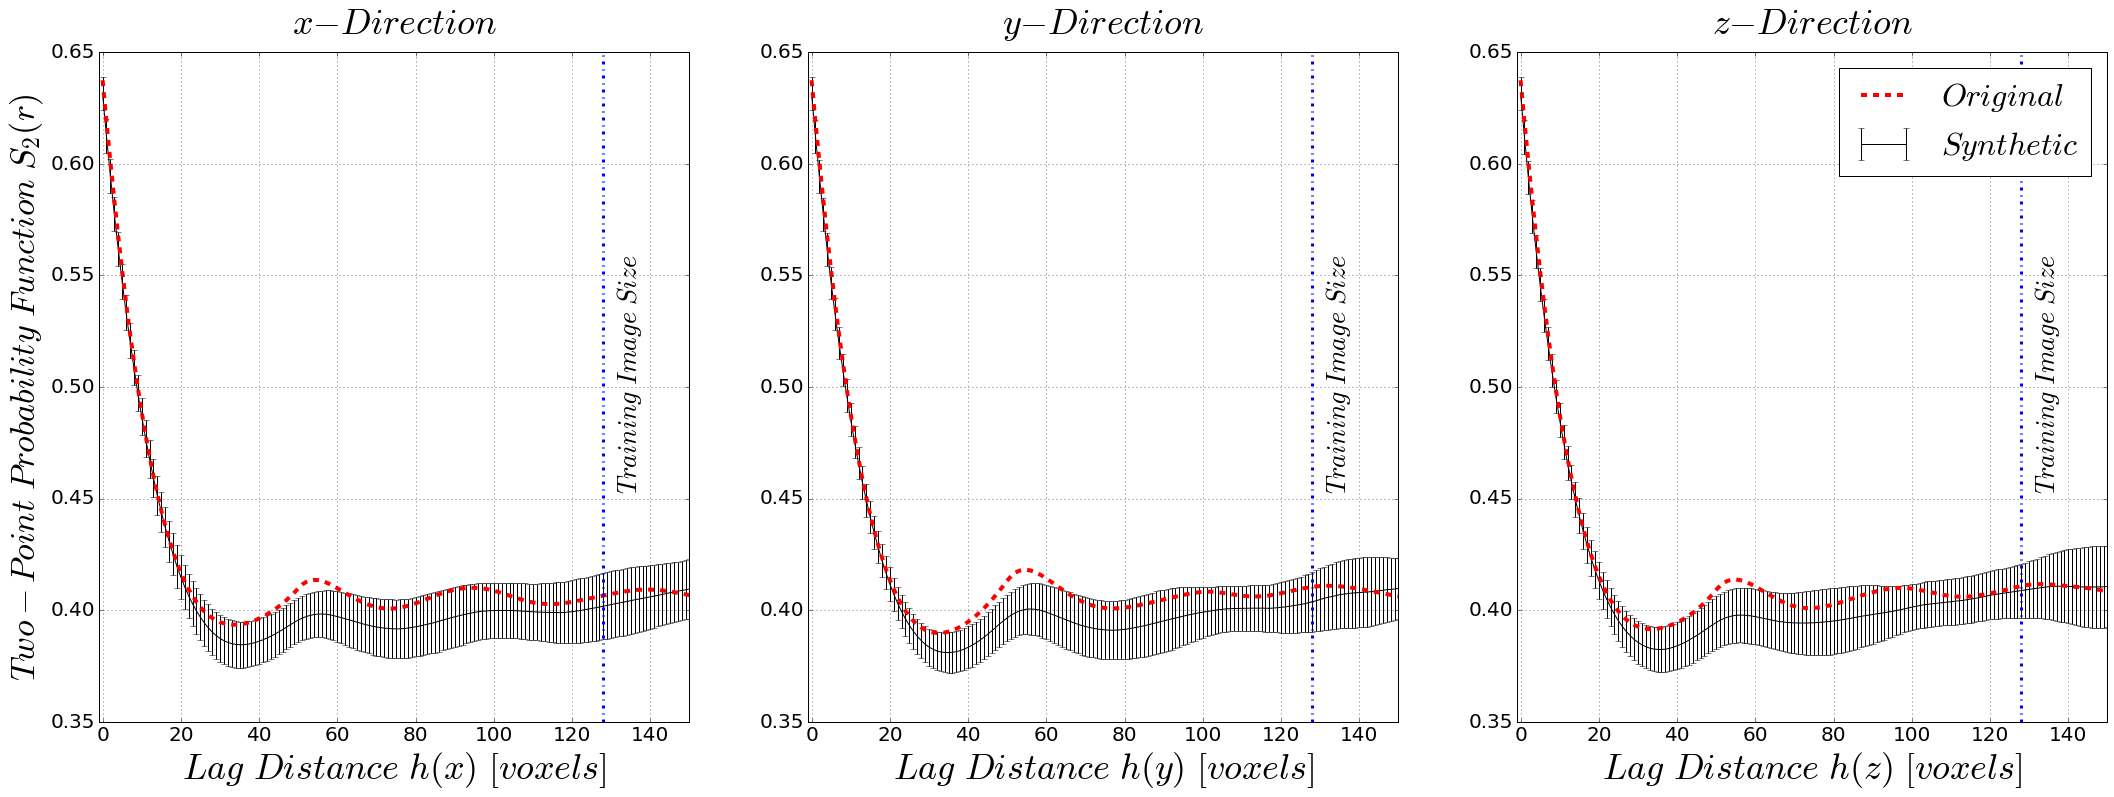

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)
for i, (j, direc) in zip(range(0, 6, 2), enumerate([r"$x$", r"$y$", r"$z$"])):    
    if j == 2:
        ax[j].errorbar(range(len(directional_averages_gph[j])), directional_averages_gph[j], yerr=directional_std_gph[j], c="black", fmt='-', label=r"$Synthetic$")
        ax[j].plot(range(len(orig_cov_gph.values.T[j])), orig_cov_gph.values.T[j], linestyle="--", linewidth=4, c="red", label=r"$Original$")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.55,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        ax[j].legend(fontsize=32)
    else:
        ax[j].errorbar(range(len(directional_averages_gph[j])), directional_averages_gph[j], yerr=directional_std_gph[j], c="black", fmt='-')
        ax[j].plot(range(len(orig_cov_gph.values.T[j])), orig_cov_gph.values.T[j], linestyle="--", linewidth=4, c="red")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.55,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        
    for tick in ax[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    for tick in ax[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
for j, direc in enumerate([r"$x$", r"$y$", r"$z$"]):
    ax[j].set_title(direc+r"$-Direction$", fontsize=36, y=1.02) 
    ax[j].set_xlabel(r"$Lag \ Distance \ h($"+direc+"$) \ [voxels]$", fontsize=36) 

ax[0].set_ylabel(r"$Two-Point \ Probability \ Function \ S_2(r)$", fontsize=34)    
for ax_handle in ax.flatten():
    ax_handle.set_xlim(-1, 150)
    ax_handle.grid()

## Directional Correlation Function

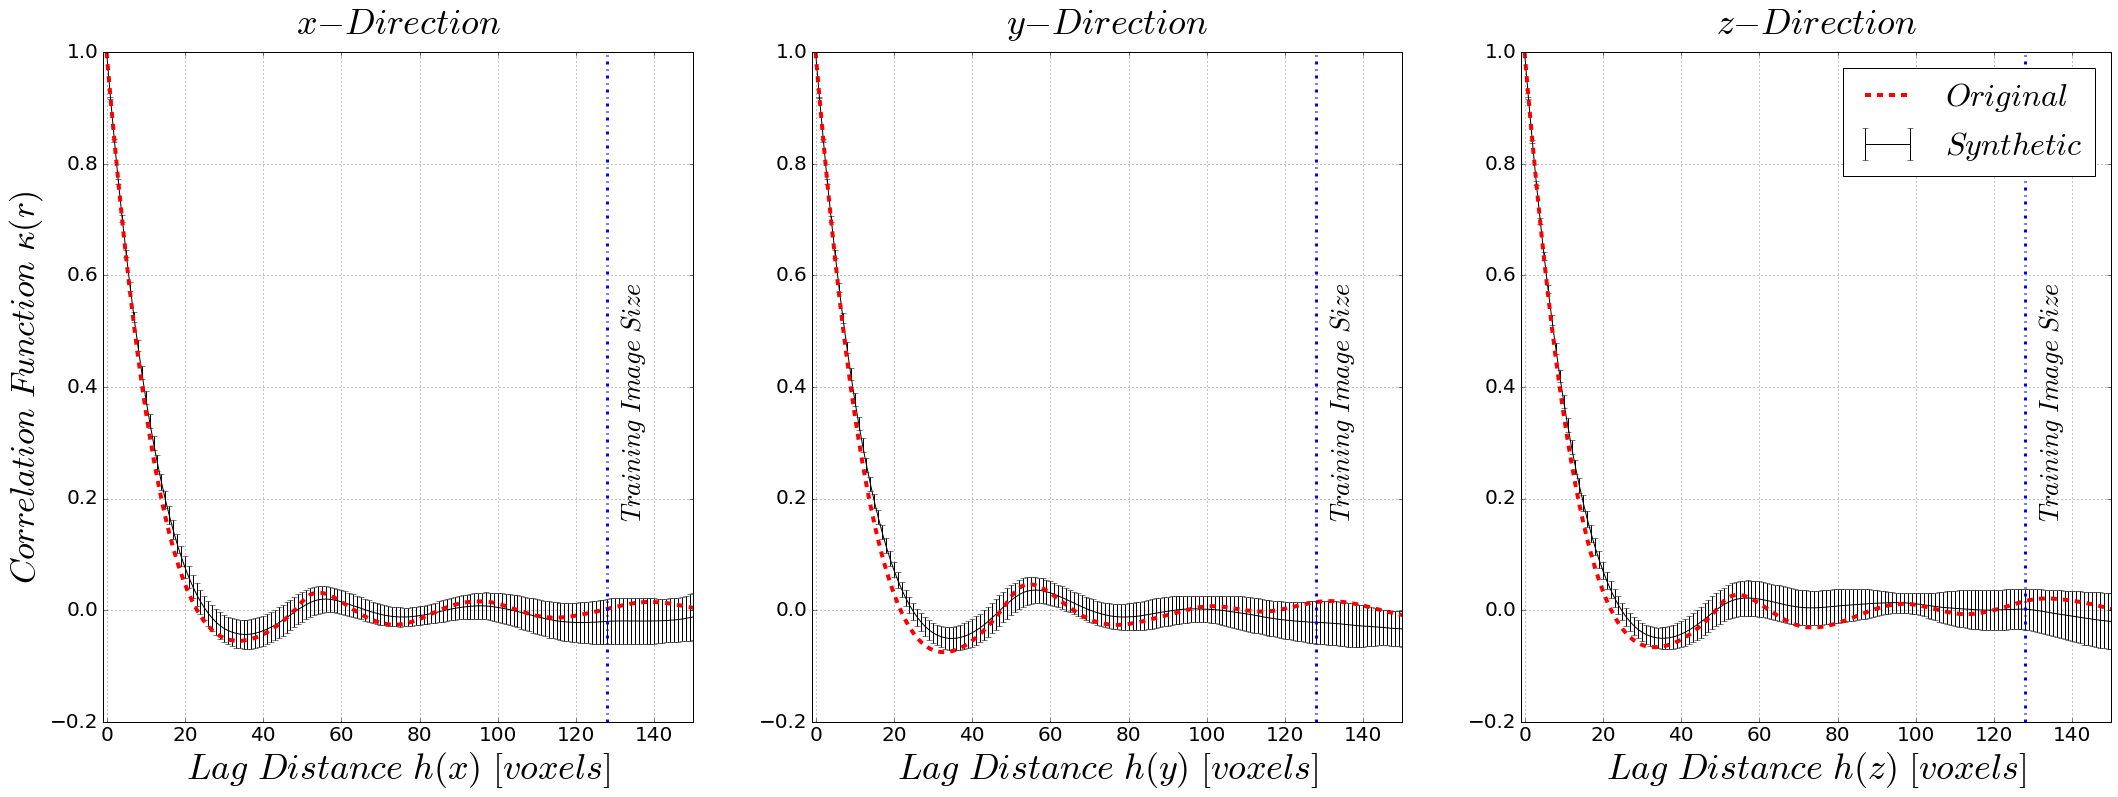

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(36, 12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)
for i, (j, direc) in zip(range(0, 6, 2), enumerate([r"$x$", r"$y$", r"$z$"])):    
    if j == 2:
        ax[j].errorbar(range(len(directional_averages_normalized[j])), directional_averages_normalized[j], yerr=directional_std_normalized[j], c="black", fmt='-', label=r"$Synthetic$")
        ax[j].plot(range(len(orig_normalized[j])), orig_normalized[j], linestyle="--", linewidth=4, c="red", label=r"$Original$")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.55,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        ax[j].legend(fontsize=32)
    else:
        ax[j].errorbar(range(len(directional_averages_normalized[j])), directional_averages_normalized[j], yerr=directional_std_normalized[j], c="black", fmt='-')
        ax[j].plot(range(len(orig_normalized[j])), orig_normalized[j], linestyle="--", linewidth=4, c="red")
        ax[j].axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
        ax[j].text(data_dic["tisize"]+3., 0.55,r'$Training \ Image \ Size$',rotation=90, fontsize=26)
        
    for tick in ax[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    for tick in ax[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
for j, direc in enumerate([r"$x$", r"$y$", r"$z$"]):
    ax[j].set_title(direc+r"$-Direction$", fontsize=36, y=1.02) 
    ax[j].set_xlabel(r"$Lag \ Distance \ h($"+direc+"$) \ [voxels]$", fontsize=36) 

ax[0].set_ylabel(r"$Correlation \ Function \ \kappa(r)$", fontsize=34)   
for ax_handle in ax.flatten():
    ax_handle.set_xlim(-1, 150)
    ax_handle.grid()

## Correlation Function Plot and Chord Size

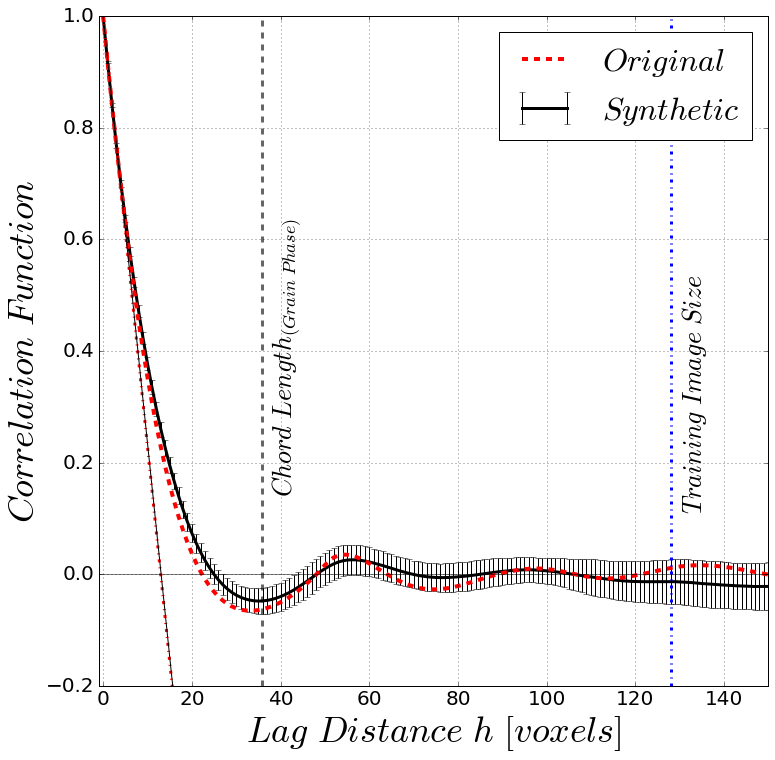

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.errorbar(range(len(radial_averaged_corr)), radial_averaged_corr, yerr=radial_std_corr, c="black", elinewidth=1, fmt='-', label=r"$Synthetic$", linewidth=3)
ax.plot(range(len(correlation_func_orig)), correlation_func_orig, linestyle="--", linewidth=4, c="red", label=r"$Original$")

slope_range = np.array(range(0, 20, 1))
ax.plot(slope_range, slope_range*float(slope_orig_corr)+1., linestyle="-.", color="red", linewidth=3)
ax.plot(slope_range, slope_range*float(slope_synth_corr)+1., linestyle="-", color="black", linewidth=1)

ax.axvline(data_dic["tisize"], color="blue", linestyle="-.", linewidth=3)
ax.text(data_dic["tisize"]+2., 0.5, r'$Training \ Image \ Size$',rotation=90, fontsize=26)


ax.axvline(orig_chord_length, color="black", linestyle="--", linewidth=3, alpha=0.6)
ax.text(orig_chord_length+2., 0.6, r'$Chord \ Length_{(Grain \ Phase)}$',rotation=90, fontsize=26)

ax.axhline(0.0, linestyle="-", color="black", alpha=0.5)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.set_xlabel(r"$Lag \ Distance \ h \ [voxels]$", fontsize=36) 

ax.set_ylabel(r"$Correlation \ Function$", fontsize=36)    
ax.set_xlim(-1, 150)
ax.set_ylim(-0.2, 1.0)
ax.grid()  
ax.legend(fontsize=32) 

#fig.savefig("figures/beadpack_radial_averaged_dcgan_correlation_function.png", bbox_extra_artists=None, bbox_inches='tight',dpi=72)